## Import electricity data

In [1]:
using CSV, DataFrames, JuMP, Gurobi

# need to change the path if you rerun it
df_price = CSV.read("./data/DayAheadSpotPrices.csv", DataFrame)[:, 2:5]

# The test data starts from here
start_ind = 5882
horizon = 168
end_ind = start_ind+horizon-1

# Data
cEl = df_price[start_ind:end_ind,1] 

# Define sets and constants
hours = 1:horizon
hours_2 = 1:(horizon-1)

P_nom = 1
# Reference for computing relative value
C_ref = sum(cEl[h] * P_nom for h in hours) 

5512.980000000002

## Since the efficiency loss relation is inherently nonlinear, we approximate it using piece-wise linear approximation to keep the MILP problem solvable. 

In [2]:
cubic(x; zeta) = x*(1 - zeta*((P_nom-x)/0.5)^2)

# Create piece-wise linear approximation
function create_section_data(zeta)
    sec_data = [
        (lb=0.5, eta_lb=0.0, ub=0.7452, eta_ub=0.0, slope=0.0, intercept=0.0),
        (lb=0.7452, eta_lb=0.0, ub=0.8556, eta_ub=0.0, slope=0.0, intercept=0.0),
        (lb=0.8556, eta_lb=0.0, ub=0.95, eta_ub=0.0, slope=0.0, intercept=0.0),
        (lb=0.95, eta_lb=0.0, ub=1.115, eta_ub=0.0, slope=0.0, intercept=0.0),
        (lb=1.115, eta_lb=0.0, ub=1.2629, eta_ub=0.0, slope=0.0, intercept=0.0),
        (lb=1.2629, eta_lb=0.0, ub=1.5, eta_ub=0.0, slope=0.0, intercept=0.0)
    ]
    
    for i in 1:length(sec_data)
        lb = sec_data[i][:lb]
        ub = sec_data[i][:ub]
        eta_lb = cubic(lb; zeta)
        eta_ub = cubic(ub; zeta)
        slope = (eta_ub - eta_lb) / (ub - lb)
        intercept = eta_ub - slope * ub
        sec_data[i] = (lb=lb, eta_lb=eta_lb, ub=ub, eta_ub=eta_ub, slope=slope, intercept=intercept)
    end
                
    return sec_data
end

create_section_data (generic function with 1 method)

## Optimization model (MILP solved using Gurobi with academic license)

In [3]:
using JuMP, Gurobi

function EfficiencyLosses(
        P_nom, #nominal power uptake (MW)
        P_max, #maximal power uptake (MW)
        P_min, #minimal power uptake (MW)
        S_max, #maximal energy capacity(MWh)
        Delta_max, #maximal power ramp up (MW)
        zeta #relative efficiency losses at P_min
    )
    sec = 1:6
    # Create section data
    sec_data = create_section_data(zeta)
    
    model = Model(Gurobi.Optimizer)
    set_attribute(model, "TimeLimit", 80000)
    set_attribute(model, "Presolve", 0)
    set_optimizer_attribute(model, MOI.Silent(), true)

    @variables(model, begin
        P_min <= P[h = hours] <= P_max
        -Delta_max <= Delta[h = hours] <= Delta_max
        -S_max <= S[h = hours] <= S_max
        C
        R
        P_s[s in sec, h in hours]
        P_eff[h in hours]
        z[s in sec, h in hours], Bin
    end)

    @constraints(model, begin
        Cost_obj, C == sum(cEl[h] * P[h] for h in hours)
        Storage[h in hours_2], S[h + 1] == S[h] + (P_eff[h] - P_nom)
        RateOfChange[h in hours_2], Delta[h + 1] == P[h + 1] - P[h]
        Start, S[1] == 0 
        Target, P_nom * horizon == sum(P_eff[h] for h in hours)
        zSec[h in hours], sum(z[s,h] for s in sec) == 1
        pSec[h in hours], sum(P_s[s,h] for s in sec) == P[h]
        Efficiency[h in hours], P_eff[h] == sum(sec_data[s][:slope] * P_s[s, h] + z[s,h] * sec_data[s][:intercept] for s in sec) # !!!
    end)

    for s in sec
        lb = sec_data[s][:lb]
        ub = sec_data[s][:ub]

        @constraint(model, [h in hours], P_s[s,h] <= z[s,h] * ub)
        @constraint(model, [h in hours], P_s[s,h] >= z[s,h] * lb)
    end

    @objective(model, Min, C)
    
    optimize!(model)

    results = Dict()
    results[:C] = value(C)
    results[:P] = [value(P[h]) for h in hours]
    results[:Delta] = [value(Delta[h]) for h in hours]
    results[:S] = [value(S[h]) for h in hours]

    return results
end
# model, C, R = EfficiencyLosses(0.95, 1.2, 3, 0.05, 0, 'C', nothing)

EfficiencyLosses (generic function with 1 method)

In [4]:
results = EfficiencyLosses(
    1, # P_nom [MW]
    1.2, # P_max [MW]
    0.5, # P_min [MW]
    6, # S_max [Hr]
    0.25, # Delta_max [MV]
    0.02 # Efficiency loss [-]
)

Set parameter Username
Set parameter LicenseID to value 2589360
Academic license - for non-commercial use only - expires 2025-11-23
Set parameter TimeLimit to value 80000
Set parameter Presolve to value 0


Dict{Any, Any} with 4 entries:
  :P     => [1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2  …  1.2, 1.2, 0.9…
  :Delta => [-0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, -…
  :S     => [0.0, 0.195485, 0.39097, 0.586455, 0.78194, 0.977426, 1.17291, 1.36…
  :C     => 5273.92

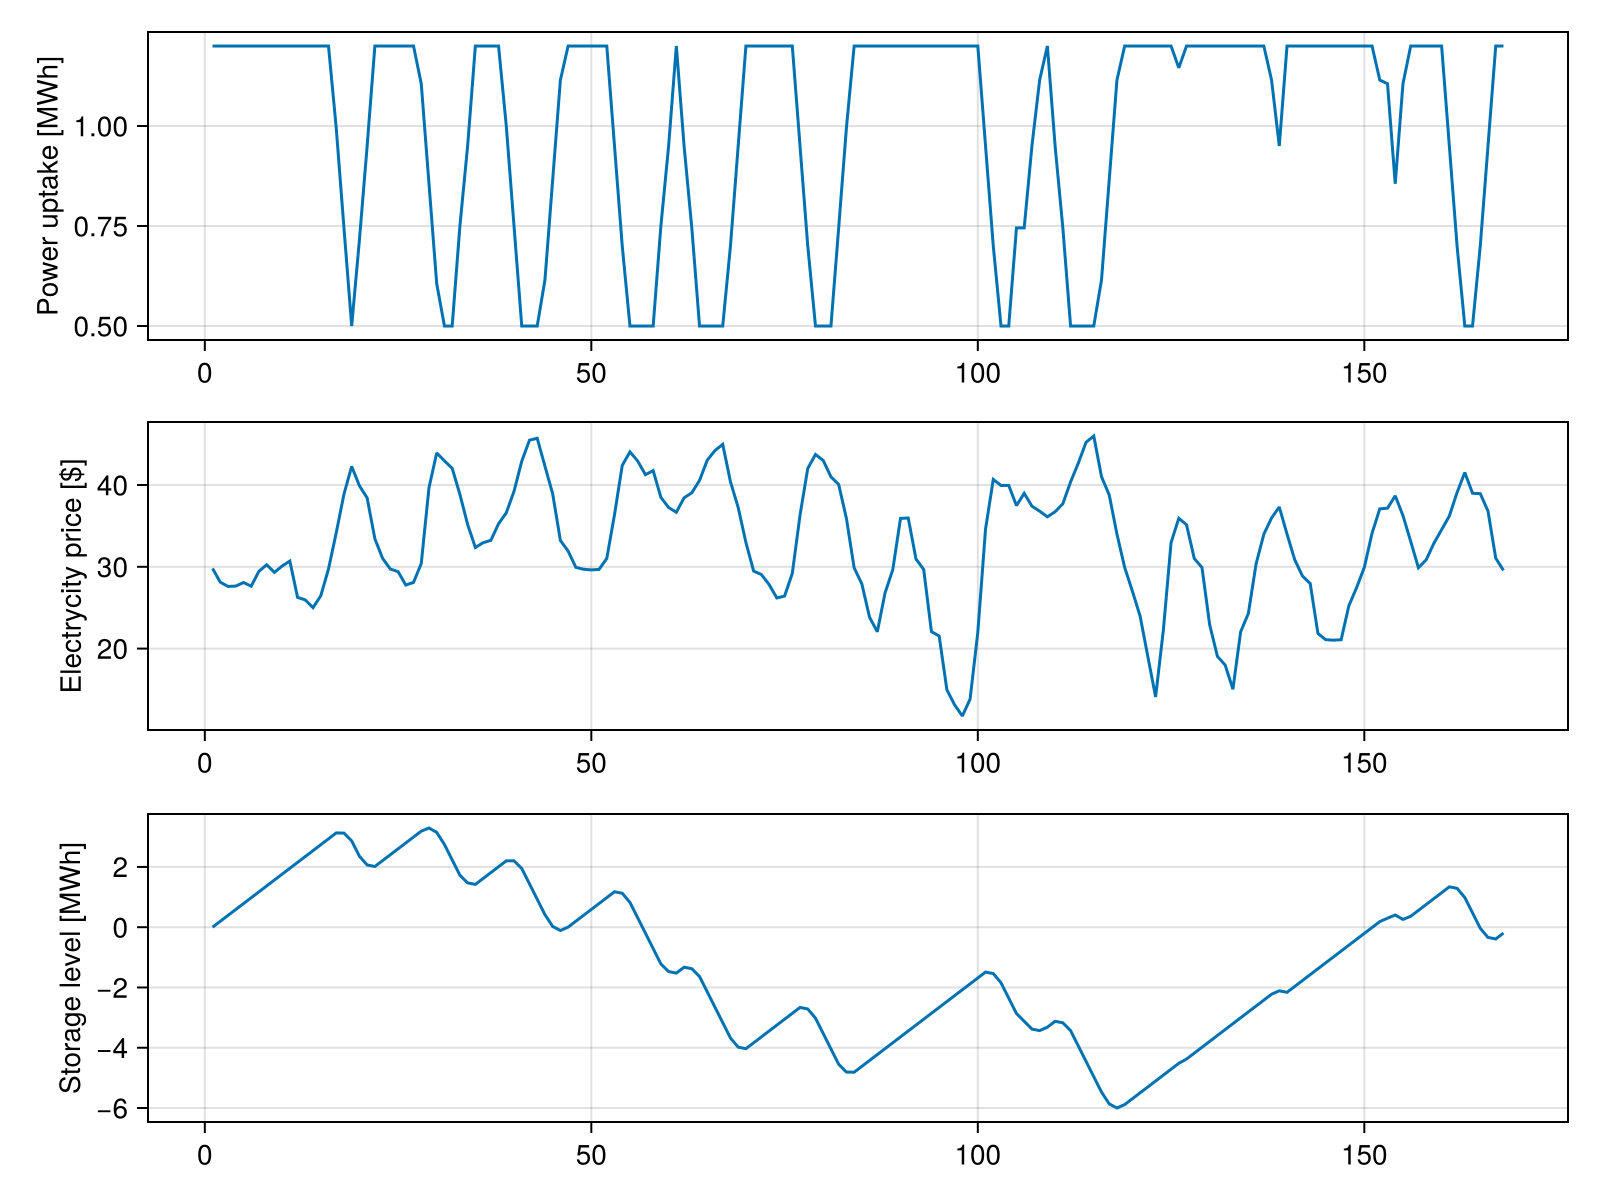

In [7]:
using CairoMakie

power = results[:P]
prices = df_price[start_ind:end_ind,1]
storages = results[:S]

f = Figure(size = (800, 600))
ax_power = Axis(f[1, 1], ylabel="Power uptake [MWh]")
ax_elec_price = Axis(f[2, 1], ylabel="Electrycity price [\$]")
ax_storage_level = Axis(f[3, 1], ylabel="Storage level [MWh]")

power_uptake = lines!(ax_power, hours, power, label = ["shutdown"])
elec_price = lines!(ax_elec_price, hours, prices, label = ["shutdown"])
storage_level = lines!(ax_storage_level, hours, storages, label = ["shutdown"])
save("figures/deterministic_opt.png", f; px_per_unit = 6.0)

f

In [8]:
using JSON

# Convert the dictionary to a JSON string
json_string = JSON.json(results)

# Write the JSON string to a file named "data.json"
open("./data/oracle.json", "w") do file
    write(file, json_string)
end

5423